In [2]:
%alias package {__import__('sys').executable} -m pip install --quiet --upgrade %l

In [5]:
session_storage = 'downloads'

import os
os.makedirs(session_storage, exist_ok=True)

In [6]:
%package fsspec

import fsspec

fs_dataset = fsspec.filesystem(
    'simplecache', 
    target_protocol='https', 
    cache_storage=session_storage
)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [7]:
%package pandas swifter scikit-learn xgboost numpy

import pandas as pd

import swifter
swifter.set_defaults(
    npartitions=None,
    dask_thres=1,
    scheduler='processes',
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False
)


import sklearn as skl
import sklearn.base
import sklearn.compose
#import sklearn.ensemble
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.svm

import xgboost

import numpy as np

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires absl-py~=0.10, but you have absl-py 1.3.0 which is incompatible.
tensorflow-gpu 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 22.11.23 which is incompatible.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.22.4 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.


/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [8]:
#%package scikit-learn-intelex

#import sklearnex
#sklearnex.patch_sklearn()

## Dataset

In [12]:
dataset_lyrics = None
with fs_dataset.open('https://github.com/cse158-fa22-team-pushystrokers/datasets/raw/main/dataset-lyrics.csv.gz') as f:
    dataset_lyrics = (
        pd.read_csv(
            f, 
            compression='gzip'
        ).astype({
            'artist': 'category',
            'year': 'datetime64',
            'genre': 'category'
        }, copy=False)
    )

In [13]:
dataset_lyrics

,song,year,artist,genre,lyrics
0,ego-remix,2009-01-01,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,then-tell-me,2009-01-01,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem..."
2,honesty,2009-01-01,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,you-are-my-rock,2009-01-01,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,black-culture,2009-01-01,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...
235989,who-am-i-drinking-tonight,2012-01-01,edens-edge,Country,"I gotta say Boy, after only just a couple of d..."
235990,liar,2012-01-01,edens-edge,Country,I helped you find her diamond ring You made me...
235991,last-supper,2012-01-01,edens-edge,Country,Look at the couple in the corner booth Looks a...
235992,christ-alone-live-in-studio,2012-01-01,edens-edge,Country,When I fly off this mortal earth And I'm measu...


In [14]:
dataset_lyrics.drop(
    dataset_lyrics.index[
        dataset_lyrics['genre']
            .isin(['Other', 'Not Available'])
    ], 
    inplace=True
)
dataset_lyrics['genre'] = dataset_lyrics['genre'].cat.remove_unused_categories()

## Plots

In [15]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
def set_constrained_layout(plt):
    plt.rcParams['figure.constrained_layout.use'] = True
set_constrained_layout(plt)

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def subplots(
    n, 
    ncols = 1, visible = False, 
    *args, **kwargs
):
    fig, axs = plt.subplots(
        *args, **kwargs,
        ncols=ncols, 
        nrows=int(np.ceil(n / ncols))
    )
    for ax in axs.flatten():
        ax.set(visible=visible)
    return fig, axs

### Sample Count Per Genre

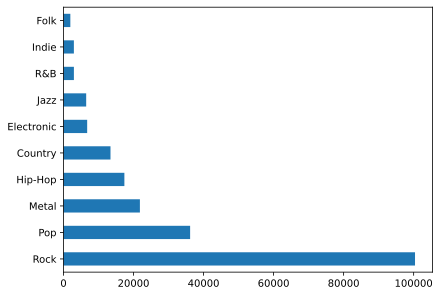

In [17]:
_ = dataset_lyrics['genre'].value_counts().plot(kind='barh')

### Top Artists by Sample Count (25)

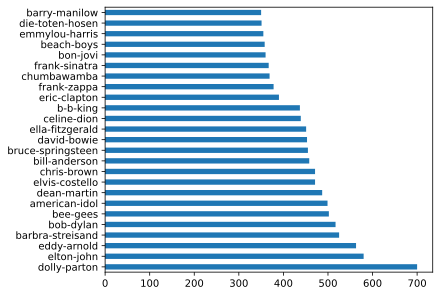

In [18]:
_ = dataset_lyrics['artist'].value_counts().head(25).plot(kind='barh')

### Word Clouds

In [31]:
%package wordcloud

import wordcloud

def _df_lyrics_generate_wordclouds_per_genre(df):
    df_genre_lyrics = df.groupby('genre', observed=True)['lyrics'].agg(' '.join)
    def _f(lyrics):
        wc = wordcloud.WordCloud(background_color=None, mode='RGBA')
        return wc, wc.generate(lyrics)
    return df_genre_lyrics.swifter.apply(_f)
    
def _df_lyrics_plot_wordclouds_per_genre(df):
    df_wcs = _df_lyrics_generate_wordclouds_per_genre(df)

    fig, axs = subplots(n=len(df_wcs), ncols=3)
    for ax, (genre, (wc, im)) in zip(
        axs.flatten(), 
        df_wcs.items()
    ):
        ax.set(visible=True, title=genre)
        ax.axis('off')
        ax.imshow(im)

    return fig

_df_lyrics_plot_wordclouds_per_genre(dataset_lyrics).show()

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


: 

: 

## Models

In [ ]:
def make_dataframe_transformer(cls):
    class cls_(cls):
        def transform(self, *args, **kwargs):
            res = super().transform(*args, **kwargs)
            if isinstance(res, pd.Series):
                return res.to_frame()
            return pd.DataFrame(res)
    return cls_

In [ ]:
%package joblib

import joblib

class BaseParallelTransformer(skl.base.TransformerMixin):
    def __init__(self, n_jobs, func, kwargs_func={}):
        super().__init__()
        self.n_jobs = n_jobs
        self.func = func
        self.kwargs_func = kwargs_func

    def fit(self, _X, _y=None):
        return self

    def transform(self, Xs, _y=None):
        return joblib.Parallel(n_jobs=self.n_jobs)(
            joblib.delayed(self.func)(X, **self.kwargs_func) 
                for X in Xs
        )

### Baseline Model

In [ ]:
%package nltk

import nltk
nltk.download('all')

#### Category Transformer (One-hot)

In [ ]:
cat_transformer_baseline = (
    skl.preprocessing.OneHotEncoder(
        handle_unknown='ignore'
    )
)

#### Text Transformer (Tokenization & Lemmatization)

In [ ]:
class WordTokenizer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        super().__init__(
            n_jobs=n_jobs,
            func=nltk.word_tokenize,
            kwargs_func=kwargs
        )

class WordNetLemmatizer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        base = nltk.stem.WordNetLemmatizer()
        super().__init__(
            n_jobs=n_jobs,
            func=lambda tokens: list(map(base.lemmatize, tokens)),
            kwargs_func=kwargs
        )

class SnowballStemmer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        base = nltk.stem.SnowballStemmer(**kwargs)
        super().__init__(
            n_jobs=n_jobs,
            func=lambda tokens: list(map(base.stem, tokens)),
            kwargs_func={}
        )

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import string

tokens_blocked = (
    set(nltk.corpus.stopwords.words('english'))
        | set(string.punctuation)
)
tokenizer_baseline = skl.pipeline.Pipeline([
    ('filter_cap',
        BaseParallelTransformer(
            n_jobs=-1, 
            func=lambda text: text.lower() 
        )
    ),
    ('tokenizer', WordTokenizer(n_jobs=-1, language='english')),
    ('filter_tokens', 
        BaseParallelTransformer(
            n_jobs=-1, 
            func=lambda tokens: filter(
                lambda token: token not in tokens_blocked,
                tokens
            )
        )
    ),
    ('lemmatizer', WordNetLemmatizer(n_jobs=-1)),
    ('stemmer', SnowballStemmer(n_jobs=-1, language='english'))
])

In [ ]:
text_transformer_baseline = skl.pipeline.Pipeline([
    *tokenizer_baseline.steps,
    ('token_count_vec', 
        skl.feature_extraction.text.CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=None,
            lowercase=False,
            analyzer='word',
            ngram_range=(1, 2)
        )
    ),
    ('token_freq_vec', 
        skl.feature_extraction.text.TfidfTransformer()
    ),
])

#### Cross Validator (Grid Search w/ Logistic Regression)

In [ ]:
model_cv_baseline = skl.model_selection.GridSearchCV(
    skl.linear_model.LogisticRegression(
        max_iter=1000
    ),
    param_grid={
        'class_weight': ['balanced'],
        'solver': ['saga'],
        'C': np.logspace(start=-2, stop=-1, num=3),
    }, 
    cv=skl.model_selection.RepeatedStratifiedKFold(n_splits=2, n_repeats=1),
    scoring='balanced_accuracy',
    #n_jobs=-1,
    verbose=3
)

In [ ]:
model_cv_gboost = skl.model_selection.GridSearchCV(
    xgboost.XGBClassifier(
        booster='gbtree',
        objective='multi:softmax',
        tree_method='gpu_hist', 
        predictor='gpu_predictor',
        sampling_method='gradient_based',
        enable_categorical=True,
        n_jobs=-1
    ),
    param_grid={
        'learning_rate': [.1, .005],
        'n_estimators': [200],
        'max_depth': [30],
        'subsample': [.75],

        #'gamma': [.1],
        #'reg_alpha': [.1],
        #'reg_lambda': [.1]
    },
    cv=skl.model_selection.RepeatedStratifiedKFold(n_splits=2, n_repeats=1),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=3
)

#### Predictor

In [ ]:
def _model_lyrics_genre_baseline(df_lyrics):
    predictor = skl.pipeline.Pipeline([
        ('feature_sel', skl.compose.ColumnTransformer([
            #('cat', cat_transformer_baseline, ['artist']),
            ('text', text_transformer_baseline, 'lyrics')
        ])),#, n_jobs=-1)),
        #('scaler', skl.preprocessing.StandardScaler(with_mean=False)),
        ('classifier_cv', model_cv_baseline)
        #('classifier_cv', model_cv_gboost)
    ])

    return predictor.fit(
        #df_lyrics[['artist', 'lyrics']],
        df_lyrics[['lyrics']],
        df_lyrics['genre']
    )

KeyboardInterrupt: ignored

In [ ]:
predictor_baseline = _model_lyrics_genre_baseline(
    dataset_lyrics#.sample(10000)
)

In [ ]:
predictor_baseline.named_steps['classifier_cv'].best_params_

AttributeError: ignored

In [ ]:
predictor_baseline.named_steps['classifier_cv'].best_score_

AttributeError: ignored

### Neural Network (LSTM RNN)

In [19]:
%package tensorflow

import tensorflow as tf
from tensorflow import keras as keras

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


2022-11-30 16:24:56.303943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 16:24:57.792333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib/:/opt/conda/lib/
2022-11-30 16:24:57.792733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/c

#### Text Transformer

In [20]:
%package spacy

import spacy
#import spacy_transformers
spacy.prefer_gpu()
spacy.cli.download('en_core_web_lg', False, False, '--quiet')

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [21]:
class KerasTextVectorizer(skl.base.TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.base = keras.layers.TextVectorization(
            *args, **kwargs
        )

    def fit(self, X, _y=None):
        self.base.adapt(X)
        return self

    def transform(self, X, _y=None):
        return self.base(X)

In [22]:
class SpacyTextVectorizer(KerasTextVectorizer):
    def __init__(self, *args, **kwargs):
        nlp = spacy.load('en_core_web_lg')
        super().__init__(
            *args, 
            vocabulary=list(nlp.vocab.strings),
            **kwargs
        )

    def fit(self, _X, _y=None):
        return self

#### Classifier

In [26]:
%package scikeras

import scikeras as skeras
import scikeras.wrappers
#import scikeras.utils.transformers

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [24]:
def KerasTextClassifier(*args, **kwargs):
    class _class(skeras.wrappers.KerasClassifier):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

            self.n_features_in_ = None
            self._user_target_encoder = (
                skl.preprocessing.OneHotEncoder(
                    sparse=False
                )
            )

        @property
        def target_encoder(self):
            return self._user_target_encoder

    _inst = None

    def _build_model(optimizer='adam'):
        nonlocal _inst

        n_features = _inst.n_features_in_
        n_classes = np.size(_inst._user_target_encoder.categories_)

        input_dim = n_features
        output_dim = n_classes

        # https://www.tensorflow.org/tutorials/keras/text_classification
        model = keras.Sequential([
            keras.layers.Embedding(
                input_dim=input_dim,
                output_dim=128,
                mask_zero=True
            ),

            keras.layers.Conv1D(
                filters=32, kernel_size=3, 
                padding='same', 
                activation='relu'
            ),
            keras.layers.MaxPooling1D(pool_size=10),
            keras.layers.Dropout(.1),

            keras.layers.Bidirectional(keras.layers.LSTM(64), return_sequence=True),
            keras.layers.Bidirectional(keras.layers.LSTM(64)),

            keras.layers.Dense(128, activation='relu'),

            keras.layers.Dense(
                output_dim,
                activation='softmax'
            )
        ])

        model.compile(
            loss='categorical_crossentropy', 
            optimizer=optimizer, 
            metrics=['accuracy']
        )

        return model

    _inst = _class(
        _build_model, 
        *args, **kwargs
    )
    return _inst

#### Predictor (Vocab From Sample)

In [18]:
def _model_lyrics_genre_nn(df_lyrics):
    X_train = df_lyrics['lyrics']
    y_train = df_lyrics[['genre']]

    encoder = KerasTextVectorizer(
        max_tokens=None,
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        #ngrams=(1, 2),
        output_mode='int', # TODO tf_idf
        #sparse=True,
    )

    X_train = encoder.fit_transform(X_train)

    clf = KerasTextClassifier(
        callbacks=[
            #keras.callbacks.EarlyStopping(
            #    monitor='loss', 
            #    patience=3, 
            #    min_delta=0.0001
            #),
            #keras.callbacks.LambdaCallback(
            #    on_train_end=lambda logs: print(logs)
            #)
        ]
    )
    clf.initialize(X_train, y_train)
    
    model = skl.model_selection.GridSearchCV(
        clf,
        param_grid={
            'epochs': [5],
            'batch_size': [1024]
        },
        cv=skl.model_selection.RepeatedStratifiedKFold(
            n_splits=3, n_repeats=1
        ),
        #cv=skl.model_selection.KFold(
        #    n_splits=5, shuffle=True
        #),
        #n_jobs=-1,
        verbose=3
    )

    model.fit(X_train, y_train)

    return model

model_nn = _model_lyrics_genre_nn(
    dataset_lyrics#.sample(2000)
)

2022-11-30 16:08:16.450535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 16:08:17.296461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9635 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/5


2022-11-30 16:09:08.005205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-11-30 16:09:10.446359: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcaa01a4130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-30 16:09:10.446422: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce RTX 2080 Ti, Compute Capability 7.5
2022-11-30 16:09:10.469681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-30 16:09:10.815877: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 [==============================] - 47s 284ms/step - loss: 1.5260 - accuracy: 0.5147
Epoch 2/5
137/137 [==============================] - 36s 262ms/step - loss: 1.3184 - accuracy: 0.5700
Epoch 3/5
137/137 [==============================] - 37s 270ms/step - loss: 1.2631 - accuracy: 0.5838
Epoch 4/5
137/137 [==============================] - 31s 226ms/step - loss: 1.2344 - accuracy: 0.5914
Epoch 5/5
69/69 [==============================] - 2s 20ms/step
[CV 1/3] END .........batch_size=1024, epochs=5;, score=0.586 total time= 3.1min
Epoch 1/5
137/137 [==============================] - 38s 246ms/step - loss: 1.5345 - accuracy: 0.5147
Epoch 2/5
137/137 [==============================] - 33s 242ms/step - loss: 1.3334 - accuracy: 0.5682
Epoch 3/5
137/137 [==============================] - 33s 241ms/step - loss: 1.2800 - accuracy: 0.5784
Epoch 4/5
137/137 [==============================] - 31s 227ms/step - loss: 1.2450 - accuracy: 0.5872
Epoch 5/5
69/69 [==============================] 

In [19]:
model_nn.best_score_

0.5865290835306961

In [20]:
model_nn.cv_results_

{'mean_fit_time': array([170.5245777]),
 'std_fit_time': array([11.23632873]),
 'mean_score_time': array([3.00641362]),
 'std_score_time': array([0.15275772]),
 'param_batch_size': masked_array(data=[1024],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 1024, 'epochs': 5}],
 'split0_test_score': array([0.5856181]),
 'split1_test_score': array([0.58852814]),
 'split2_test_score': array([0.58544101]),
 'mean_test_score': array([0.58652908]),
 'std_test_score': array([0.0014154]),
 'rank_test_score': array([1], dtype=int32)}

#### Predictor (Vocab From Pretrained)

In [27]:
def _model_lyrics_genre_nn_spacy(df_lyrics):
    X_train = df_lyrics['lyrics']
    y_train = df_lyrics[['genre']]

    encoder = SpacyTextVectorizer(
        max_tokens=None,
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        #ngrams=(1, 2),
        output_mode='int', # TODO tf_idf
        #sparse=True,
    )

    X_train = encoder.fit_transform(X_train)

    clf = KerasTextClassifier(
        callbacks=[
            #keras.callbacks.EarlyStopping(
            #    monitor='loss', 
            #    patience=3, 
            #    min_delta=0.0001
            #),
            #keras.callbacks.LambdaCallback(
            #    on_train_end=lambda logs: print(logs)
            #)
        ]
    )
    clf.initialize(X_train, y_train)
    
    model = skl.model_selection.GridSearchCV(
        clf,
        param_grid={
            'epochs': [5],
            'batch_size': [512]
        },
        cv=skl.model_selection.RepeatedStratifiedKFold(
            n_splits=3, n_repeats=1
        ),
        #cv=skl.model_selection.KFold(
        #    n_splits=5, shuffle=True
        #),
        #n_jobs=-1,
        verbose=3
    )

    model.fit(X_train, y_train)

    return model

model_nn_spacy = _model_lyrics_genre_nn_spacy(
    dataset_lyrics#.sample(2000)
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/5


2022-11-30 16:28:00.982571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-11-30 16:28:03.079006: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x563fc9376020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-30 16:28:03.079077: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce RTX 2080 Ti, Compute Capability 7.5
2022-11-30 16:28:03.103751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-30 16:28:03.446243: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 [==============================] - 76s 244ms/step - loss: 1.5768 - accuracy: 0.5036
Epoch 2/5
274/274 [==============================] - 52s 190ms/step - loss: 1.5243 - accuracy: 0.5138
Epoch 3/5
274/274 [==============================] - 47s 171ms/step - loss: 1.5219 - accuracy: 0.5142
Epoch 4/5
274/274 [==============================] - 37s 134ms/step - loss: 1.5201 - accuracy: 0.5144
Epoch 5/5
137/137 [==============================] - 2s 12ms/step
[CV 1/3] END ..........batch_size=512, epochs=5;, score=0.513 total time= 4.2min
Epoch 1/5
274/274 [==============================] - 54s 183ms/step - loss: 1.5824 - accuracy: 0.5015
Epoch 2/5
274/274 [==============================] - 47s 173ms/step - loss: 1.5252 - accuracy: 0.5127
Epoch 3/5
274/274 [==============================] - 36s 130ms/step - loss: 1.5220 - accuracy: 0.5132
Epoch 4/5
274/274 [==============================] - 31s 113ms/step - loss: 1.5200 - accuracy: 0.5133
Epoch 5/5
137/137 [============================

In [28]:
model_nn_spacy.best_score_

0.5144861052127355